In [145]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, label_binarize
%matplotlib inline

### 1. Đọc dữ liệu

In [146]:
path = 'ProcessedData.csv'
raw_df = pd.read_csv(path, sep=',', encoding='utf-8')

raw_df.head(5)

,Unnamed: 0,timestamp,Temprature (Kelvin),Feels like (Kelvin),Pressure (mb),Humidity (%),Temperature Amplitude,Wind speed (m/s),Wind degree,Wind gust (m/s),...,Weather Description,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,0,1701388800,301.16,306.75,1011.0,89.0,0.0,0.51,0.0,0.0,...,scattered clouds,5.0,921.25,128.75,42.50,0.0,56.74,246.02,294.09,29.64
1,1,1701392400,301.16,306.75,1011.0,89.0,0.0,0.51,300.0,0.0,...,scattered clouds,5.0,4699.71,109.08,34.62,0.0,42.44,199.75,233.37,22.29
2,2,1701396000,301.16,306.75,1010.0,89.0,0.0,0.51,0.0,0.0,...,scattered clouds,5.0,3791.81,84.94,26.73,0.0,29.80,157.48,177.82,17.23
3,3,1701399600,300.16,304.35,1009.0,94.0,0.0,0.51,330.0,0.0,...,scattered clouds,5.0,3017.43,61.69,20.91,0.0,22.41,121.27,132.87,13.05
4,4,1701403200,299.16,299.16,1009.0,94.0,0.0,0.51,290.0,0.0,...,mist,5.0,2456.67,46.04,17.82,0.0,19.55,96.76,104.39,10.26


### 2. Chuẩn bị dữ liệu

Lấy cột Weather Description làm nhãn, kiểm tra phân phối của nhãn.

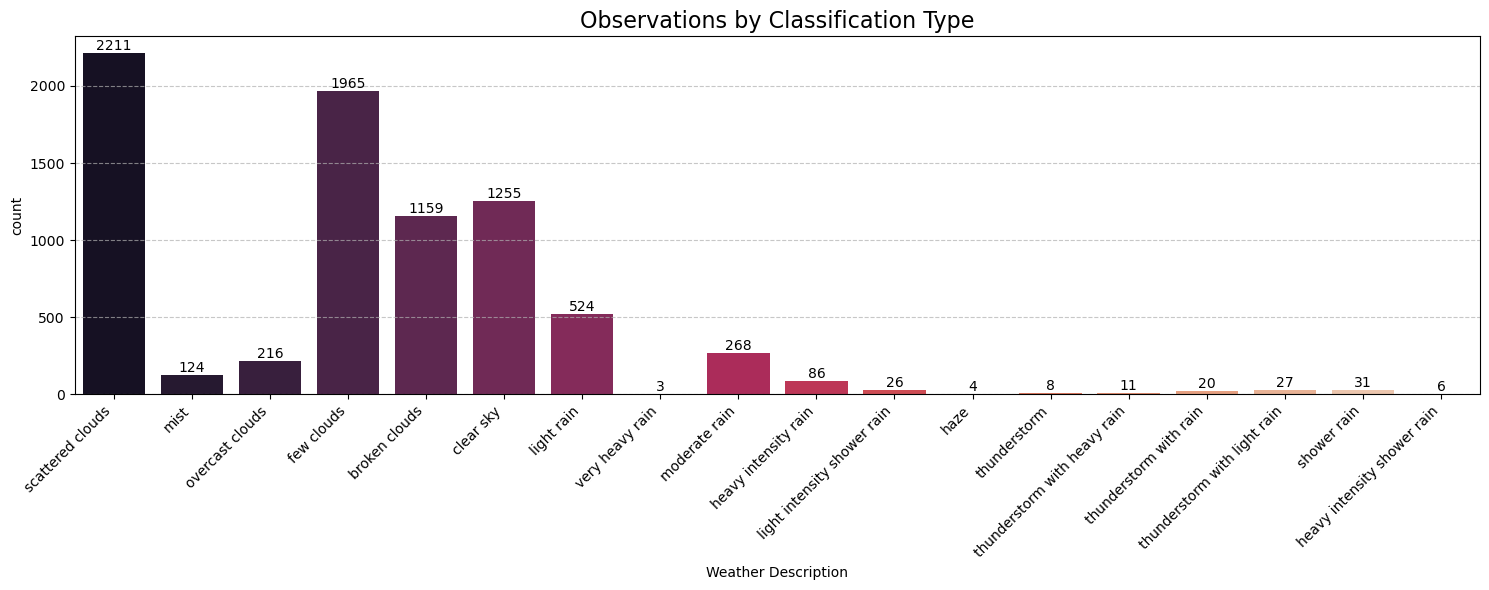

In [147]:
plt.figure(figsize=(15, 6))

# Vẽ biểu đồ countplot
ax = sns.countplot(x=raw_df['Weather Description'], palette='rocket', dodge=False)

# Thêm nhãn dữ liệu
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Xóa bảng chú thích
if ax.legend_:
    ax.legend_.remove()

# Xoay nhãn trên trục x để tránh bị chồng
plt.xticks(rotation=45, ha='right', fontsize=10)

# Thêm tiêu đề
plt.title("Observations by Classification Type", fontsize=16)

# Thêm lưới
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Gộp các nhãn lại thành các nhãn có ý nghĩa thống kê hơn.

In [148]:
# Gộp các nhãn thành nhóm lớn hơn
label_mapping = {
    'heavy intensity rain': 'Rainy',
    'shower rain': 'Rainy',
    'moderate rain': 'Rainy',
    'light rain': 'Rainy',
    'clear sky': 'Clear',
    'few clouds': 'Clear',
    'scattered clouds': 'Cloudy',
    'broken clouds': 'Cloudy',
    'overcast clouds': 'Cloudy',
    'mist': 'Misty',
    'thunderstorm': 'Rainy',
    'thunderstorm with light rain': 'Rainy',
    'thunderstorm with rain': 'Rainy',
    'thunderstorm with heavy rain': 'Rainy',
    'thunderstorm with drizzle': 'Rainy',
    'thunderstorm with heavy drizzle': 'Rainy',
    'thunderstorm with light drizzle': 'Rainy',
    'heavy thunderstorm': 'Rainy',
    'heavy intensity shower rain': 'Rainy',
    'light intensity shower rain': 'Rainy',
    'haze': 'Misty',
    'very heavy rain': 'Rainy'
}

# Áp dụng ánh xạ
raw_df['Weather Description'] = raw_df['Weather Description'].replace(label_mapping)

#### Chuẩn bị và chia các tập dữ liệu.

In [149]:
# Loại bỏ các cột không cần thiết khỏi tập dữ liệu đầu vào
X = raw_df.drop(columns=['Weather Description', 'Unnamed: 0', 'timestamp'])

# Sử dụng cột 'Weather Description' làm nhãn
y = raw_df['Weather Description']

# Binarize labels cho Precision-Recall đa lớp (One-vs-Rest)
n_classes = label_binarize(y, classes=np.unique(y)).shape[1]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Tỷ lệ chia dữ liệu
train_ratio = 0.8  # 80% train
test_ratio = 0.2   # 20% test

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

y_test_binarized = label_binarize(y_test, classes=np.unique(y))

- Lý do chọn tỷ lệ 80/20
    + Đảm bảo đủ dữ liệu huấn luyện: 80% cho tập train giúp mô hình học tốt các đặc trưng, đặc biệt với các lớp ít mẫu.
    + Đánh giá khách quan: 20% cho tập test đủ để kiểm tra độ tổng quát của mô hình.
    + Phù hợp với GridSearchCV: Tập train đủ lớn để chia nhỏ trong quá trình tìm kiếm tham số tối ưu.
    + Cân đối dữ liệu: Tỷ lệ 80/20 phổ biến, phù hợp với quy mô và tính chất dữ liệu.

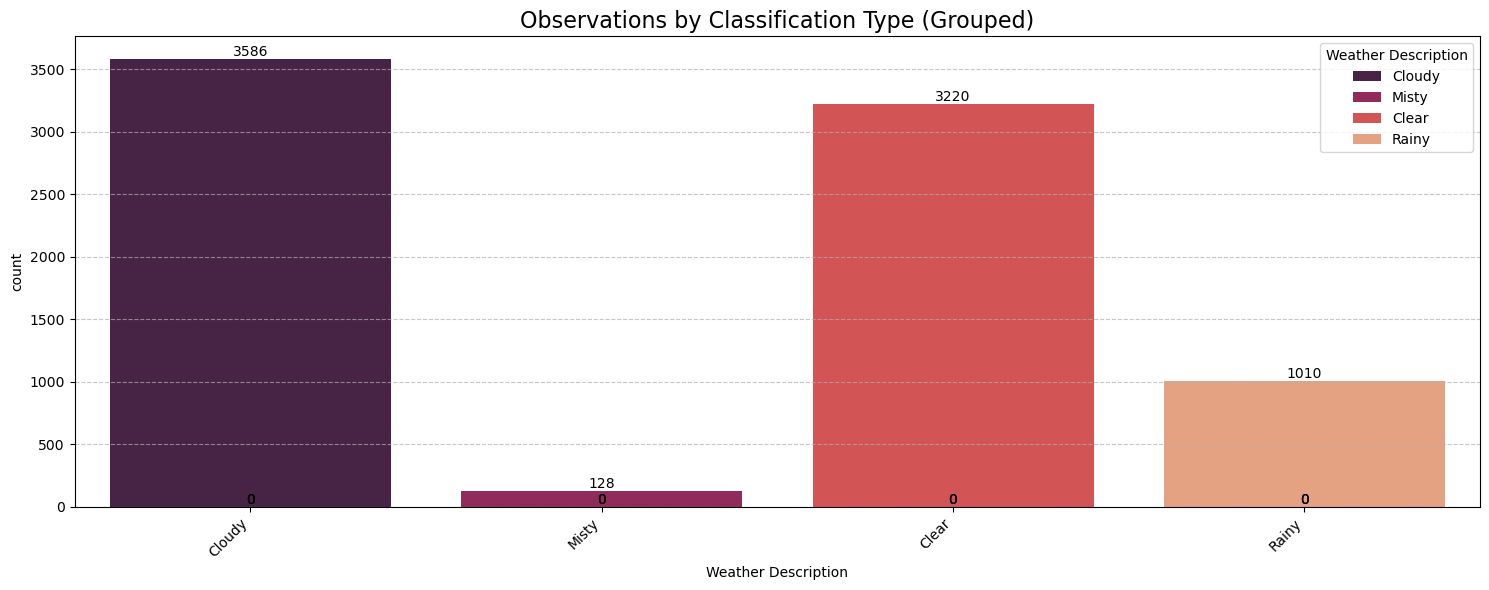

In [150]:
# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ biểu đồ countplot
ax = sns.countplot(x=y, hue=y, palette='rocket', dodge=False)

# Thêm nhãn dữ liệu lên từng cột
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Xoay nhãn trên trục x để dễ đọc
plt.xticks(rotation=45, ha='right', fontsize=10)

# Thêm tiêu đề
plt.title("Observations by Classification Type (Grouped)", fontsize=16)

# Thêm lưới ngang để dễ quan sát
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tinh chỉnh bố cục
plt.tight_layout()

plt.show()

#### Các hàm trực quan hóa.

In [151]:
def confustion_matrix_report(report, confusion_matrix, labels, title):
    # Vẽ biểu đồ
    plt.figure(figsize=(15, 6))

    # Vẽ Classification Report
    plt.subplot(1, 2, 1)
    plt.text(0.01, 1.0, "Classification Report", fontsize=12, fontweight='bold')
    plt.text(0.01, 0.5, report, {'fontsize': 10}, fontproperties='monospace')
    plt.axis('off')

    # Vẽ Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title(f'{title} Confusion Matrix (80/20)', fontsize=12)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(y_scores, title):
    # Precision-Recall Curve và Average Precision cho từng lớp
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_scores[:, i])

    # Vẽ biểu đồ Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                label=f'Class {i} (AP = {average_precision[i]:.2f})')  # Thêm "3" vì các lớp là từ 3 đến 8

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {title}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### 3. Điều chỉnh siêu tham số 

In [152]:
# Tính toán trọng số lớp (class_weight)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

# Định nghĩa tham số cho GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Khởi tạo mô hình
base_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Sử dụng GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

# Huấn luyện với grid search
grid_search.fit(X_train, y_train)

# In kết quả tìm kiếm tham số tốt nhất
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

Class weights: {'Clear': 0.6167507763975155, 'Cloudy': 0.5537643778319972, 'Misty': 15.575980392156863, 'Rainy': 1.9662747524752475}
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.7831146191552557


#### Mục đích của GridSearchCV
- GridSearchCV được sử dụng để tìm tham số tối ưu bằng cách thử các tổ hợp tham số trong param_grid, đánh giá qua cross-validation, và chọn tổ hợp cho hiệu suất tốt nhất (dựa trên accuracy).

#### Vì sao dùng param_grid như vậy?
- n_estimators: [50, 100, 200]
    + Đây là số lượng cây trong rừng (forest).
    + Giá trị thấp hơn (50) giúp mô hình nhanh nhưng có thể thiếu chính xác.
    + Giá trị cao hơn (200) tăng khả năng tổng quát nhưng cần nhiều tài nguyên hơn.
- max_depth: [10, 20, None]
    + Độ sâu tối đa của cây quyết định mức độ chi tiết mà mô hình học được từ dữ liệu.
    + 10 hoặc 20 giới hạn độ sâu để tránh overfitting, đặc biệt với dữ liệu nhiễu.
    + None cho phép cây phát triển tối đa, giúp tìm hiểu toàn bộ thông tin dữ liệu.
- min_samples_split: [2, 5, 10]
    + Số mẫu tối thiểu để tiếp tục chia tại một nút.
    + Giá trị nhỏ (2) giúp mô hình học chi tiết nhưng dễ bị overfitting.
    + Giá trị lớn hơn (10) làm mô hình tổng quát hơn, tránh overfitting trên các tập nhỏ.
   
   
##### Mục tiêu
Bộ tham số này được chọn vì chúng là các yếu tố cơ bản nhất, ảnh hưởng mạnh đến hiệu suất và tính tổng quát của RandomForestClassifier, đồng thời đảm bảo kiểm tra sự cân bằng giữa độ chính xác và chi phí tính toán.

- Random Forest là một tập hợp (ensemble) của nhiều cây quyết định (Decision Trees), nên khả năng dự đoán chính xác và ổn định cao hơn các mô hình đơn lẻ.
- Mô hình này rất hữu ích với dữ liệu phức tạp hoặc có sự không đồng nhất, nhất là dữ liệu về thời tiết.
- Khả năng xử lý tốt cả dữ liệu phân loại (categorical) và số (numerical).
- Tự động đánh giá tầm quan trọng của các đặc trưng, giúp tối ưu hóa hiệu năng mà không cần nhiều điều chỉnh thủ công.

### 4. Đánh giá mô hình cuối cùng trên test set

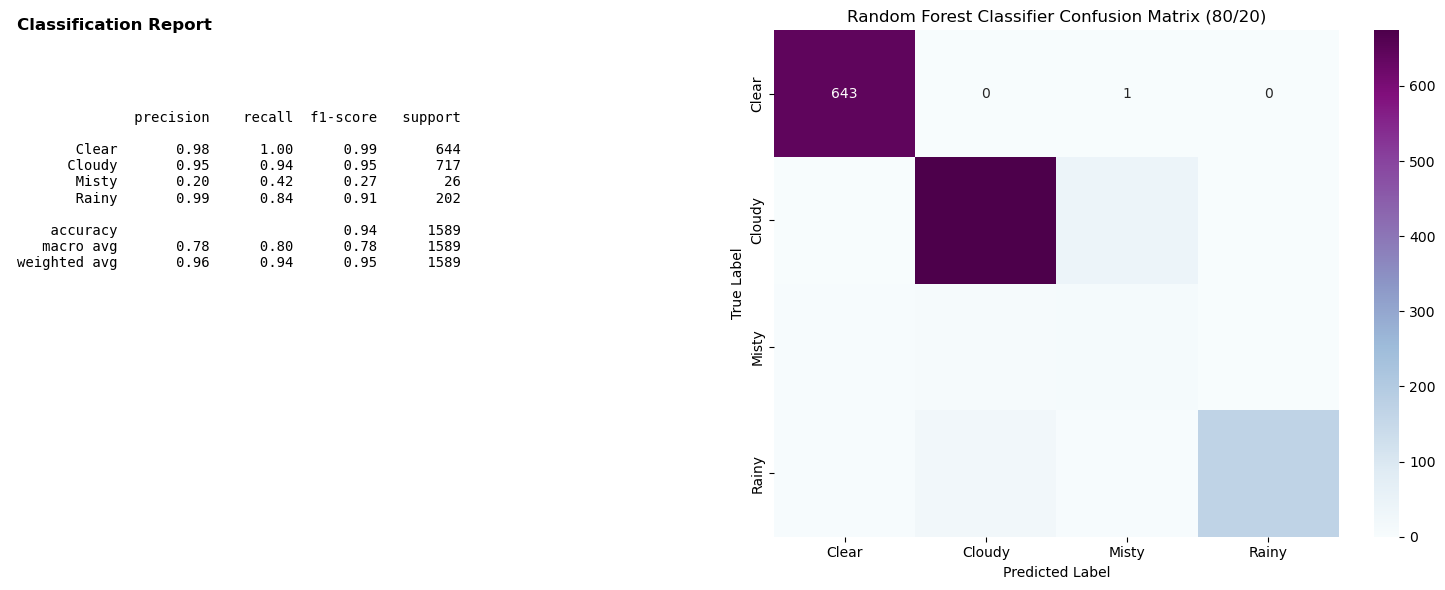

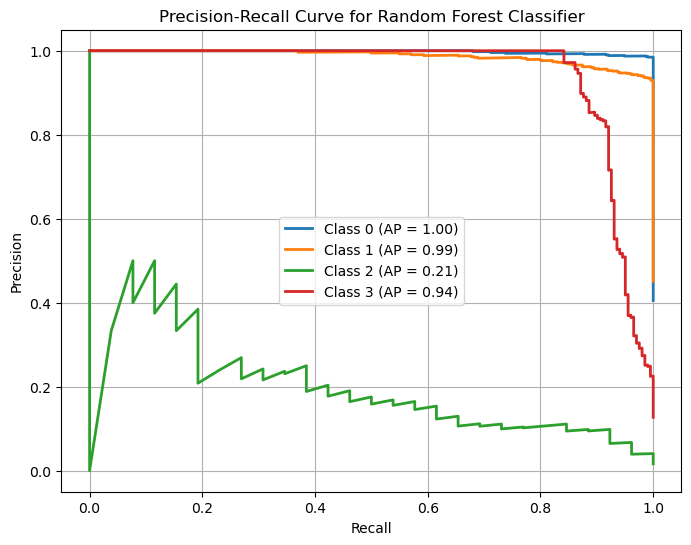

In [153]:
# Dự đoán trên test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_scores = grid_search.best_estimator_.predict_proba(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.classes_)

# Trực quan hóa báo cáo và sơ đồ
confustion_matrix_report(report_text, cm, grid_search.best_estimator_.classes_, 'Random Forest Classifier')
plot_precision_recall_curve(y_scores, "Random Forest Classifier")

- Kết quả mà mô hình trả ra là nhãn.
- Ý nghĩa của kết quả: Nhãn phân loại cho biết điều kiện thời tiết dự đoán tại thời điểm đầu vào.

#### Đánh giá mô hình:
- Accuracy:
    + Độ chính xác tổng thể của mô hình đạt 94%, cho thấy mô hình có hiệu suất rất tốt trong việc dự đoán các lớp.

- Macro Avg vs Weighted Avg:
    + Macro Avg (precision, recall, f1-score):
        - Precision: 0.78, Recall: 0.8, F1-Score: 0.78.
        - Điểm số này thấp hơn vì nó tính trung bình đều cho tất cả các lớp, bao gồm cả những lớp có ít dữ liệu. Điều này cho thấy mô hình hoạt động chưa tốt trên các lớp hiếm.
    + Weighted Avg: Precision, recall, và F1-score đều cao (khoảng 0.94-0.95), do các lớp lớn hơn chi phối kết quả.

- Lớp "Misty':
    + Recall rất thấp (0.42), nghĩa là mô hình gần như không thể dự đoán chính xác các lớp này.
    + Nguyên nhân là do số lượng mẫu của các lớp này quá ít, dẫn đến mất cân bằng dữ liệu.

- Lỗi phổ biến (Confusion Matrix):
    - Lớp "Misty" bị nhầm lẫn nhiều với các lớp khác, điều này có thể do đặc trưng của các lớp này chưa được mô hình học tốt.

- Precision-Recall Curve (Random Forest Classifier):
    - Diện tích dưới đường cong (AP - Average Precision) cho thấy hiệu suất dự đoán trên từng lớp:
        - Lớp 3 ("Clear") có AP cao nhất (0.77) và lớp 6 (0.66), phù hợp với kết quả từ confusion matrix.
        - Lớp 3 có AP rất thấp (0.03), chứng tỏ mô hình gần như không phân biệt được lớp này.
        - Các lớp 4, 7, và 8 có AP dưới mức trung bình, dao động từ 0.22 đến 0.27.

#### Tổng quan:
- Mô hình hoạt động xuất sắc trên các lớp có số lượng mẫu lớn.
- Tuy nhiên, nó gặp khó khăn trong việc dự đoán các lớp có ít dữ liệu hoặc có đặc điểm không rõ ràng.

### 5. Kiểm tra lại mô hình với K-Fold Cross Validation

In [154]:
# Sử dụng Stratified K-Fold Cross Validation để bảo đảm phân bổ nhãn đều trong các tập con
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Áp dụng Cross-Validation để tính độ chính xác
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=kfold, scoring='accuracy')

# In kết quả
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard Deviation: {np.std(cv_scores):.4f}')

Cross-Validation Accuracy Scores: [0.94901813 0.94939577 0.9444864 ]
Mean Accuracy: 0.9476
Standard Deviation: 0.0022


#### Nhận xét:
Độ chính xác từng fold (Cross-Validation Accuracy Scores):
- Mô hình đạt độ chính xác dao động từ 0.9444 đến 0.9493 trong các fold, cho thấy mô hình hoạt động khá ổn định và đạt hiệu suất tốt trên từng tập con.

Độ chính xác trung bình (Mean Accuracy):
- Với độ chính xác trung bình là 0.9476, mô hình cho thấy khả năng phân loại chính xác cao trên toàn bộ dữ liệu.

Độ lệch chuẩn (Standard Deviation):
- Độ lệch chuẩn là 0.002, cho thấy độ chính xác giữa các fold khá ổn định, không có sự thay đổi lớn trong kết quả.  

=> Mô hình đã tổng quát hóa.

### 6. So sánh với baseline model  
#### a. Majority Class Classifier (Dự đoán lớp phổ biến nhất)

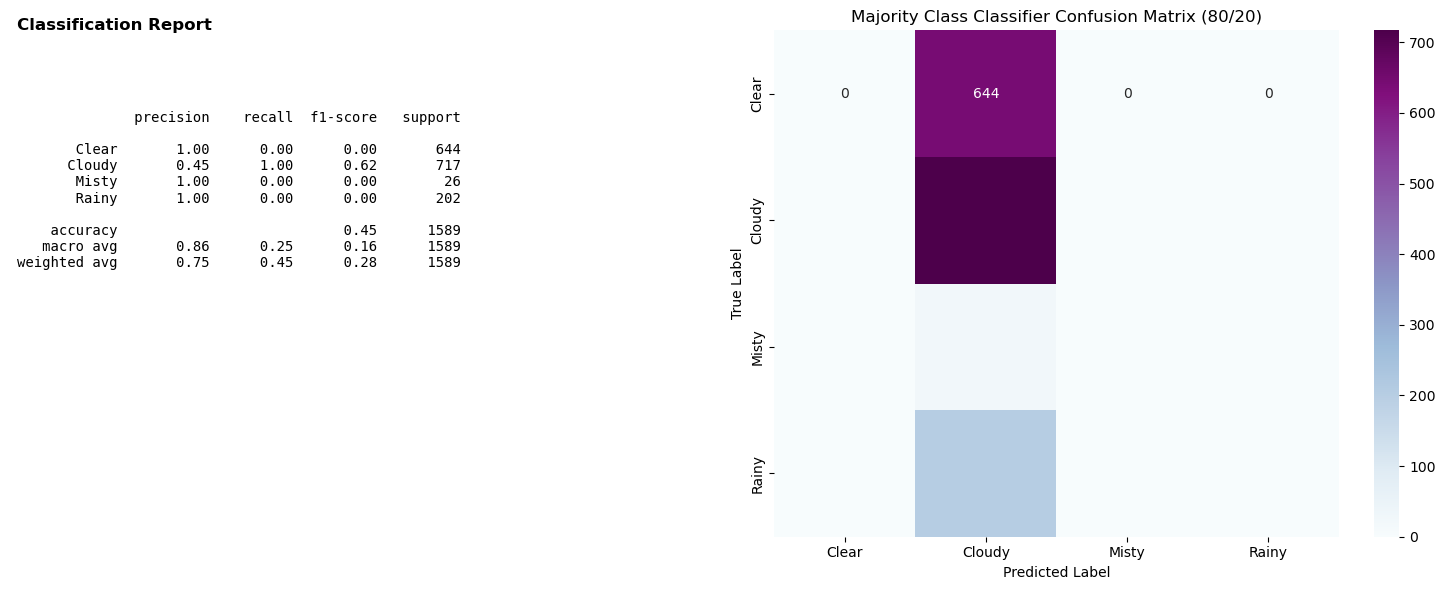

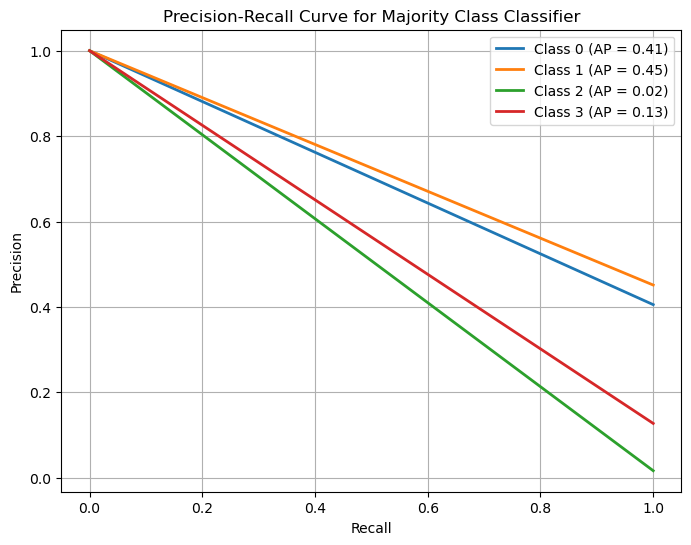

In [155]:
# Tạo mô hình baseline
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred_baseline = baseline_model.predict(X_test)
y_scores_baseline = baseline_model.predict_proba(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_baseline, labels=baseline_model.classes_)

# Trực quan hóa báo cáo và sơ đồ
confustion_matrix_report(report_text, cm, baseline_model.classes_, 'Majority Class Classifier')
plot_precision_recall_curve(y_scores_baseline, "Majority Class Classifier")

- Confusion Matrix và Classification Report (Majority Class Classifier):
    - Độ chính xác tổng thể (Accuracy): 45%, khá thấp, cho thấy mô hình chỉ dự đoán đúng khoảng 1/2 dữ liệu.
    - Giá trị F1-Score giữa các lớp có sự chênh lệch lớn:
        - Lớp "Cloudy" (62%) được dự đoán tốt hơn so với các lớp khác, nhưng vẫn còn khó khăn.
        - Lớp "Clear", "Misty", và "Rainy" có hiệu suất thấp rõ rệt, với F1-Score gần bằng 0 cho cả 3 lớp. Cho thấy mô hình không hoặc gần như không thể dự đoán chính xác 3 lớp này.
    - Macro average F1-Score (0.16) rất thấp, cho thấy hiệu suất mô hình kém đồng đều giữa các lớp.

- Precision-Recall Curve (Majority Class Classifier):
    - Diện tích dưới đường cong (AP - Average Precision) cho thấy hiệu suất dự đoán trên từng lớp:
        - Lớp 1 ("Cloudy") có AP cao nhất 0.45 và lớp 0 ("Clear") 0.41. Cao hơn rõ rệt so với các lớp khác.
        - Lớp 2 ("Misty") và lớp 3 ("Rainy") có AP rất thấp 0.02 và 0.13, chứng tỏ mô hình gần như không phân biệt được lớp này.

#### b. Random Classifier (Dự đoán ngẫu nhiên theo phân phối nhãn)

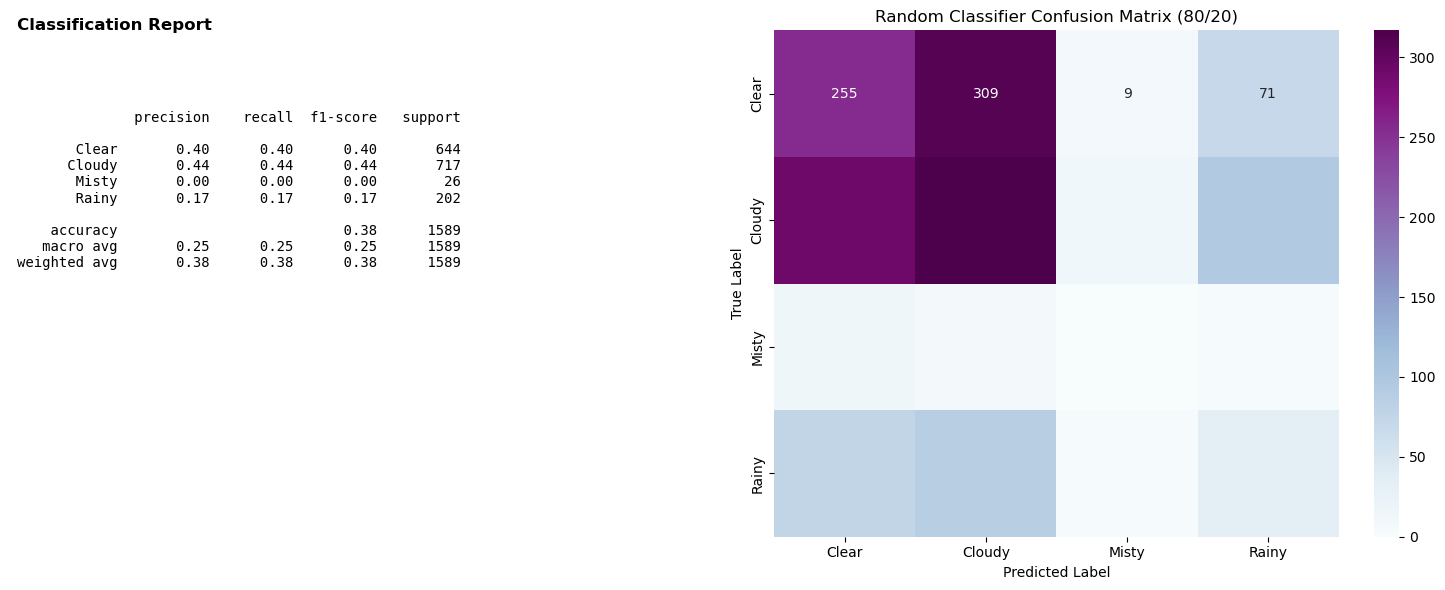

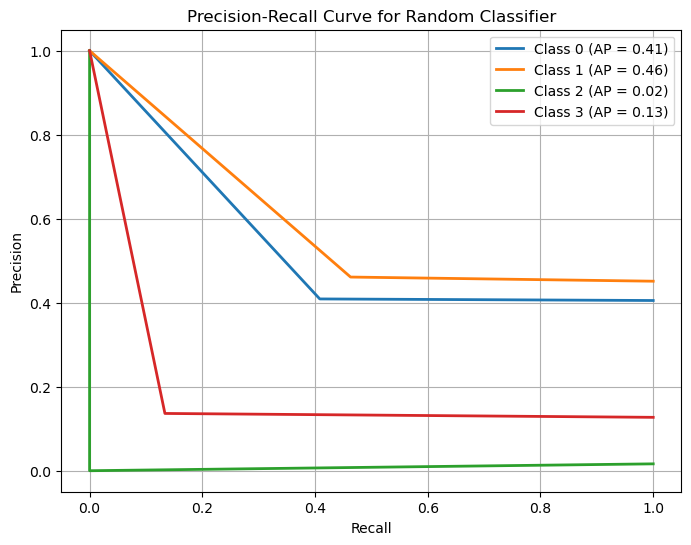

In [156]:
# Tạo mô hình baseline
baseline_model = DummyClassifier(strategy="stratified")
baseline_model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred_baseline = baseline_model.predict(X_test)
y_scores_baseline = baseline_model.predict_proba(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_baseline, labels=baseline_model.classes_)

# Trực quan hóa báo cáo và sơ đồ
confustion_matrix_report(report_text, cm, baseline_model.classes_, 'Random Classifier')
plot_precision_recall_curve(y_scores_baseline, "Random Classifier")

- Confusion Matrix và Classification Report (Random Classifier):
    - Độ chính xác tổng thể (Accuracy): 38%, khá thấp, cho thấy mô hình chỉ dự đoán đúng khoảng 1/3 dữ liệu.
    - Giá trị F1-Score giữa các lớp có sự chênh lệch lớn:
        - Lớp "Clear" (40%) và lớp "Cloudy" (44%) được dự đoán tốt hơn so với các lớp khác. Nhưng vẫn còn rất tệ
        - Lớp "Misty", và "Rainy" có hiệu suất thấp rõ rệt, với F1-Score gần bằng 0 cho cả 2 lớp. Cho thấy mô hình không thể dự đoán chính xác 2 lớp này.
    - Macro average F1-Score (0.25) rất thấp, cho thấy hiệu suất mô hình kém đồng đều giữa các lớp.

- Precision-Recall Curve (Random Classifier):
    - Diện tích dưới đường cong (AP - Average Precision) cho thấy hiệu suất dự đoán trên từng lớp:
        - Lớp 1 ("Cloudy") có AP cao nhất 0.46 và lớp 0 ("Clear") 0.41. Cao hơn rõ rệt so với các lớp khác.
        - Lớp 2 ("Misty") và lớp 3 ("Rainy") có AP rất thấp 0.02 và 0.13, chứng tỏ mô hình gần như không phân biệt được lớp này.

#### c. Logistic Regression (Linear Model as Baseline)

<Figure size 1500x600 with 0 Axes>

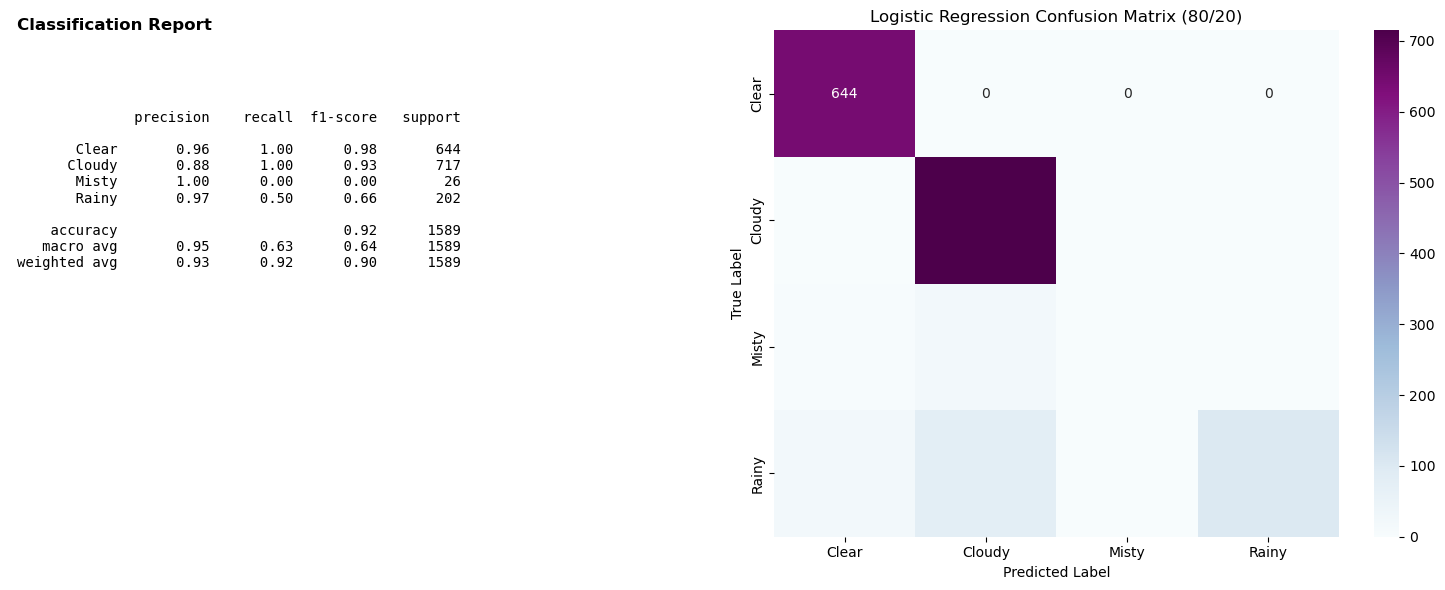

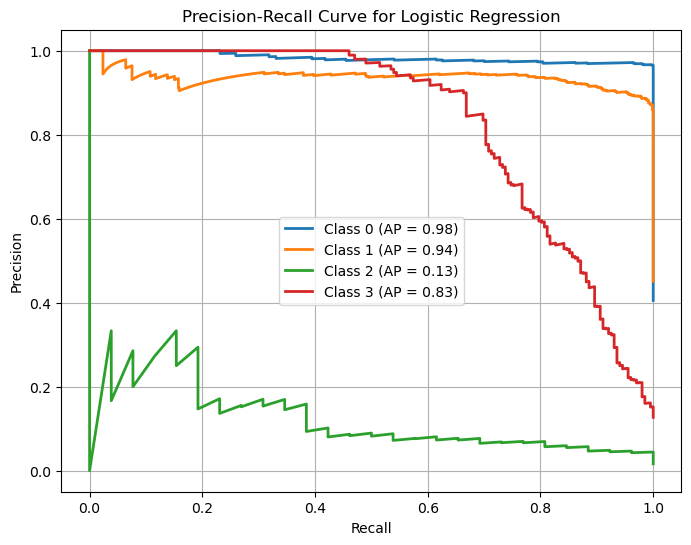

In [157]:
# Tạo mô hình baseline
baseline_model = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)
baseline_model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred_baseline = baseline_model.predict(X_test)
y_scores_baseline = baseline_model.predict_proba(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_baseline, labels=baseline_model.classes_)

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Trực quan hóa báo cáo và sơ đồ
confustion_matrix_report(report_text, cm, baseline_model.classes_, 'Logistic Regression')
plot_precision_recall_curve(y_scores_baseline, "Logistic Regression")

- Confusion Matrix và Classification Report (Logistic Regression):
    - Độ chính xác tổng thể (Accuracy): 92%, khá cao, cho thấy mô hình dự đoán gần đúng toàn bộ dữ liệu.
    - Giá trị F1-Score giữa các lớp có sự chênh lệch lớn:
        - Lớp "Clear" (98%) và lớp "Cloudy" (93%) được dự đoán tốt hơn so với các lớp khác. Cho thấy mô hình dự đoán gần như dự đoán chính xác hoàn toàn các lớp này.
        - Lớp "Misty", và "Rainy" có hiệu suất thấp rõ rệt, với F1-Score là 0% và 66%. Cho thấy mô hình không thể hoặc rất khó dự đoán chính xác 2 lớp này.
    - Macro average F1-Score (0.25) rất thấp, cho thấy hiệu suất mô hình kém đồng đều giữa các lớp.

- Precision-Recall Curve (Logistic Regression):
    - Diện tích dưới đường cong (AP - Average Precision) cho thấy hiệu suất dự đoán trên từng lớp:
        - Lớp 0 ("Clear") có AP cao nhất 0.98, lớp 1 ("Cloudy") 0.94 và lớp 3 ("Rainy") 0.83. Cao hơn rõ rệt so với các lớp khác.
        - Lớp 2 ("Misty") có AP rất thấp 0.13, chứng tỏ mô hình gần như không phân biệt được lớp này.

#### d. Decision Tree (Simple Non-Optimized Model)

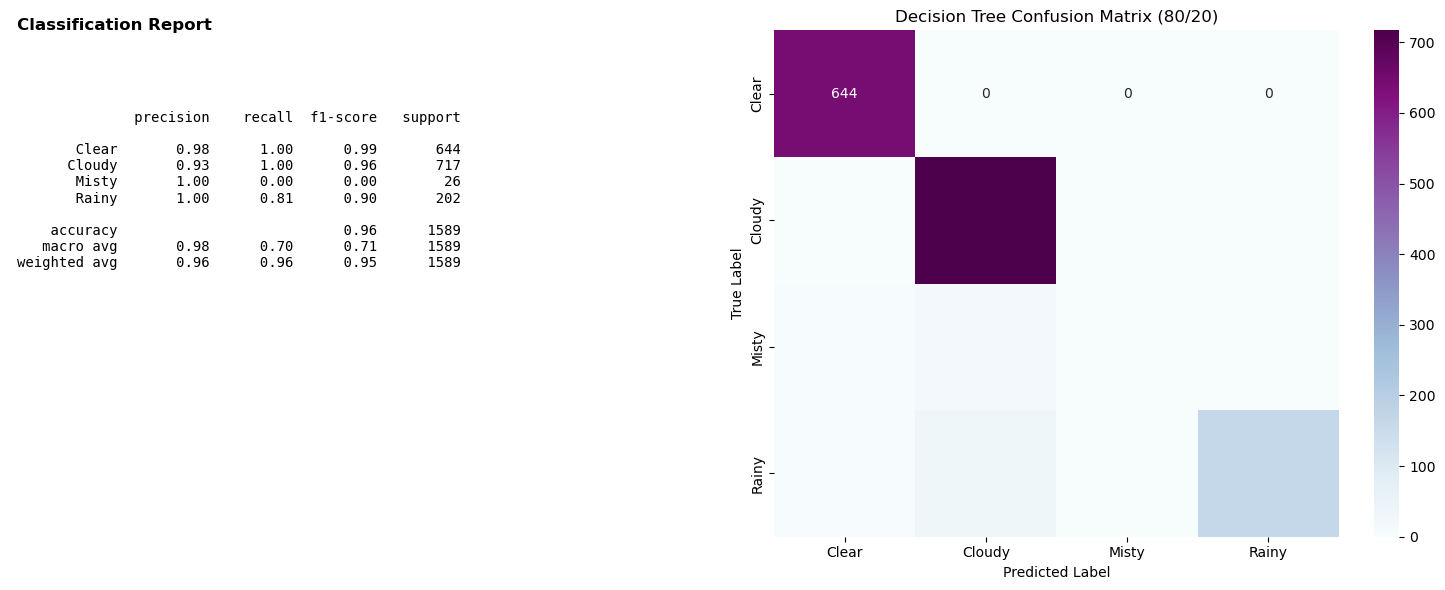

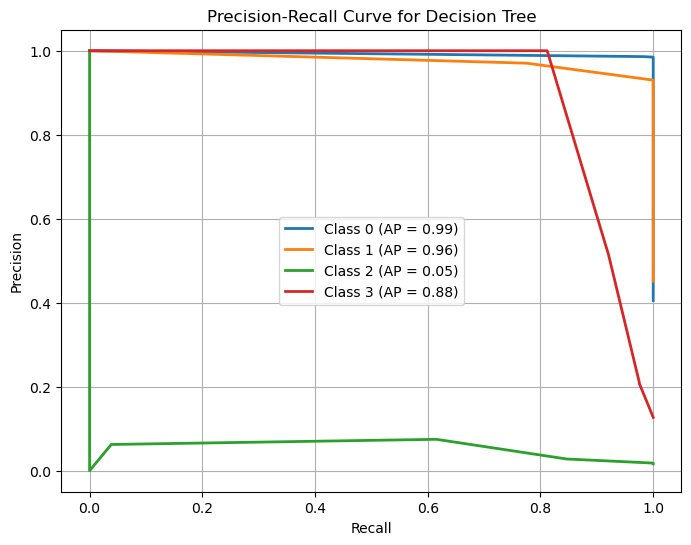

In [158]:
# Tạo mô hình baseline
baseline_model = DecisionTreeClassifier(max_depth=3, random_state=42)
baseline_model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred_baseline = baseline_model.predict(X_test)
y_scores_baseline = baseline_model.predict_proba(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_baseline, labels=baseline_model.classes_)

# Trực quan hóa báo cáo và sơ đồ
confustion_matrix_report(report_text, cm, baseline_model.classes_, 'Decision Tree')
plot_precision_recall_curve(y_scores_baseline, "Decision Tree")

- Confusion Matrix và Classification Report (Decision Tree):
    - Độ chính xác tổng thể (Accuracy): 96%, rất cao, cho thấy mô hình dự đoán gần đúng toàn bộ dữ liệu.
    - Giá trị F1-Score giữa các lớp có sự chênh lệch lớn:
        - Lớp "Clear" (99%), lớp "Cloudy" (96%) và lớp "Rainy" (90%) được dự đoán tốt hơn so với các lớp khác. Cho thấy mô hình dự đoán gần như dự đoán chính xác hoàn toàn các lớp này.
        - Lớp "Misty" có hiệu suất thấp rõ rệt, với F1-Score là 0%. Cho thấy mô hình không thể dự đoán chính xác lớp này.
    - Macro average F1-Score (0.71) trên trung bình, cho thấy hiệu suất mô hình chưa đồng đều giữa các lớp.

- Precision-Recall Curve (Decision Tree):
    - Diện tích dưới đường cong (AP - Average Precision) cho thấy hiệu suất dự đoán trên từng lớp:
        - Lớp 0 ("Clear") có AP cao nhất 0.99, lớp 1 ("Cloudy") 0.96 và lớp 3 ("Rainy") 0.88. Cao hơn rõ rệt so với các lớp khác. 
        - Lớp 2 ("Misty") có AP rất thấp 0.05, chứng tỏ mô hình gần như không phân biệt được lớp này.

#### Mô hình chính (Accuracy: 0.95)
- Precision: 0.96, Recall: 0.94, F1-Score: 0.95
- Điểm mạnh: Dự đoán chính xác các lớp phổ biến như "Clear", "Cloudy", "Rainy.
- Điểm yếu: Lớp ít gặp như "Misty" có hiệu suất rất kém.

#### Các mô hình cơ sở:
- Majority Class Classifier (Accuracy: 0.45)
    + Dự đoán lớp phổ biến nhất, recall rất thấp cho các lớp khác.

- Random Classifier (Accuracy: 0.38)
    + Dự đoán ngẫu nhiên, precision và recall rất thấp.

- Logistic Regression (Accuracy: 0.92)
    + Precision: 0.95, Recall: 0.63, F1-Score: 0.64
    + Hiệu suất khá, nhưng không tốt cho các lớp ít gặp.

- Decision Tree (Accuracy: 0.96)
    + Precision: 0.98, Recall: 0.70, F1-Score: 0.71
    + Tốt cho các lớp phổ biến, nhưng recall cho các lớp ít gặp thấp.
    
#### Kết luận:  
- Mô hình chính vượt trội về hiệu suất tổng thể, đặc biệt cho các lớp phổ biến, trong khi các mô hình cơ sở có accuracy ổn nhưng hiệu suất kém, đặc biệt với các lớp ít gặp.
- Kết quả mà mô hình trả ra là kết quả dự đoán thời tiết dựa vào các đặc trưng như nhiệt độ, gió,...
- Giúp đánh giá mức độ ô nhiễm không khí ảnh hưởng tới điều kiện thời tiết.